In this notebook, we will show you the differents steps to train step by step dly your model in this competition.

# Images Extractions

In [3]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
# !wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_train.h5
# !wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_val.h5
# !wget -q https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_test.h5

In [5]:
trainset = h5py.File("09072022_1154_train.h5", "r")
validateset = h5py.File("09072022_1154_val.h5", "r")
testset = h5py.File("09072022_1154_test.h5", "r")

In [6]:
# attributes of trainset
trainset.keys()

<KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>

In [7]:
np.array(trainset['lat'])[1].max(), np.array(trainset['lat'])[0].max(), np.array(trainset['lat'])[1].min(), np.array(trainset['lat'])[0].min()

(7.689011, 6.8738728, 7.687746, 6.8726077)

(0.0, 400.0)

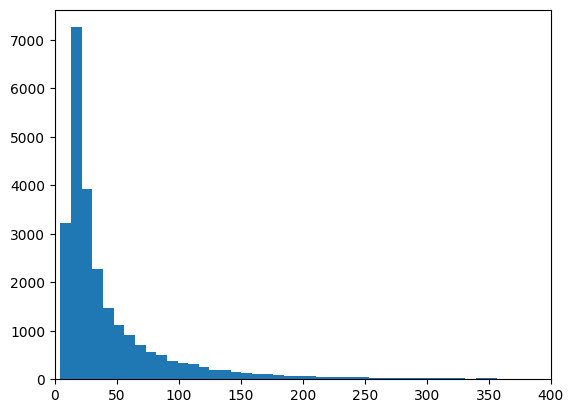

In [8]:
plt.hist(np.array(trainset['agbd']), bins = 100)
plt.xlim(0, 400)

Text(0.5, 1.0, 'Histogram of pixel values for all 12 bands')

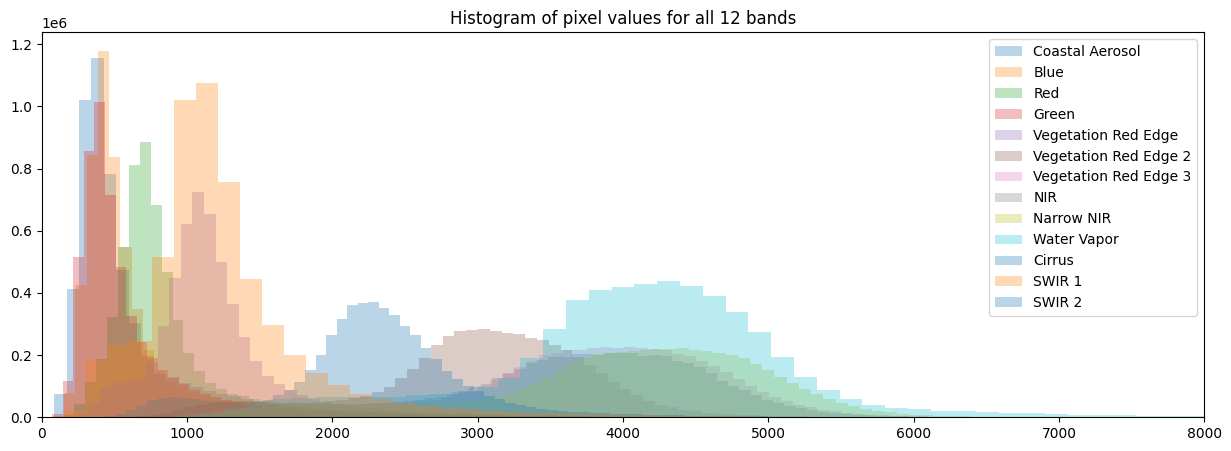

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

for i in range(0, 12):
    axs.hist(np.array(trainset['images'])[:, :, :, i].reshape(-1), bins = 100, alpha = 0.3, label = i)

axs.legend(['Coastal Aerosol', 'Blue', 'Red', 'Green', 'Vegetation Red Edge', 'Vegetation Red Edge 2', 'Vegetation Red Edge 3', 'NIR', 'Narrow NIR', 'Water Vapor', 'Cirrus', 'SWIR 1', 'SWIR 2'])
axs.set_xlim(0, 8_000)
axs.set_title('Histogram of pixel values for all 12 bands')

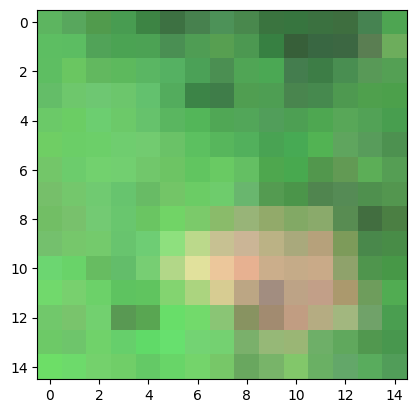

In [10]:
plt.imshow(np.array(trainset['images'])[0, :, :, [3, 2, 1]].T / 1_000)

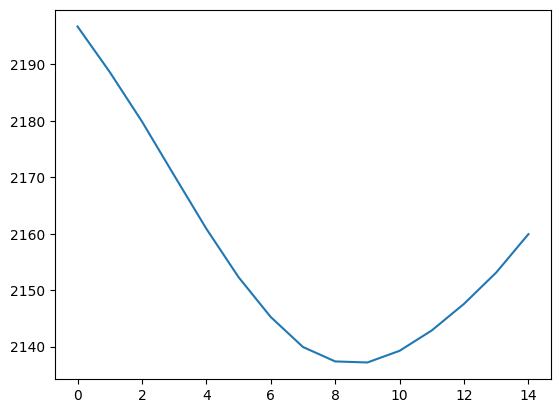

In [11]:
plt.plot(np.array(trainset['images']).mean(axis = 3).mean(axis = 0)[6])

In [5]:
trainset['images'].shape

(25036, 15, 15, 12)

In [6]:
np.array(trainset['images'])

array([[[[ 283,  377,  711, ..., 4397, 2315, 1100],
         [ 283,  388,  747, ..., 4397, 2305, 1102],
         [ 286,  385,  749, ..., 4364, 2283, 1122],
         ...,
         [ 453,  421,  786, ..., 3936, 2344, 1150],
         [ 493,  406,  792, ..., 3920, 2452, 1263],
         [ 551,  405,  871, ..., 3909, 2642, 1487]],

        [[ 280,  368,  655, ..., 4395, 2292, 1094],
         [ 280,  386,  745, ..., 4395, 2296, 1101],
         [ 283,  382,  778, ..., 4367, 2285, 1132],
         ...,
         [ 439,  426,  769, ..., 3911, 2302, 1101],
         [ 476,  422,  776, ..., 3890, 2349, 1136],
         [ 529,  421,  855, ..., 3878, 2424, 1219]],

        [[ 275,  303,  611, ..., 4390, 2238, 1046],
         [ 275,  347,  642, ..., 4390, 2263, 1068],
         [ 278,  375,  723, ..., 4370, 2282, 1124],
         ...,
         [ 416,  436,  818, ..., 3868, 2265, 1067],
         [ 446,  419,  827, ..., 3840, 2285, 1068],
         [ 490,  426,  820, ..., 3828, 2309, 1100]],

        ...,

  

In [6]:
import altair as alt

In [7]:
alt.Chart(pd.DataFrame({'latitude': np.array(trainset['lat'])[[2, 3, 4, 5, 6, 7, 8, 9]].reshape(-1), 'longitude': np.array(trainset['lon'])[[2, 3, 4, 5, 6, 7, 8, 9]].reshape(-1), 'red': np.array(trainset['images'])[[2, 3, 4, 5, 6, 7, 8, 9], :, :, 2].reshape(-1) / 700})).mark_point().encode(x = alt.X('longitude:Q', scale = alt.Scale(zero = False)), y = alt.Y('latitude:Q', scale = alt.Scale(zero = False)), color = 'red:Q')

alt.Chart(...)

In [8]:
alt.Chart(pd.DataFrame({'latitude': np.array(trainset['lat'])[[2, 3, 4, 5, 6, 7, 8, 9, 10]].reshape(-1), 'longitude': np.array(trainset['lon'])[[2, 3, 4, 5, 6, 7, 8, 9, 10]].reshape(-1), 'red': np.array(trainset['images'])[[2, 3, 4, 5, 6, 7, 8, 9, 10], :, :, 2].reshape(-1) / 700})).mark_point().encode(x = alt.X('longitude:Q', scale = alt.Scale(zero = False)), y = alt.Y('latitude:Q', scale = alt.Scale(zero = False)), color = 'red:Q')

alt.Chart(...)

In [ ]:
np.array(trainset['lon'])[1]

array([[[-2.941374 ],
        [-2.9412832],
        [-2.9411924],
        [-2.9411018],
        [-2.941011 ],
        [-2.94092  ],
        [-2.9408295],
        [-2.9407387],
        [-2.9406478],
        [-2.9405572],
        [-2.9404664],
        [-2.9403758],
        [-2.940285 ],
        [-2.9401941],
        [-2.9401035]],

       [[-2.941374 ],
        [-2.9412832],
        [-2.9411924],
        [-2.9411018],
        [-2.941011 ],
        [-2.94092  ],
        [-2.9408295],
        [-2.9407387],
        [-2.9406478],
        [-2.9405572],
        [-2.9404664],
        [-2.9403758],
        [-2.940285 ],
        [-2.9401941],
        [-2.9401035]],

       [[-2.941374 ],
        [-2.9412832],
        [-2.9411924],
        [-2.9411018],
        [-2.941011 ],
        [-2.94092  ],
        [-2.9408295],
        [-2.9407387],
        [-2.9406478],
        [-2.9405572],
        [-2.9404664],
        [-2.9403758],
        [-2.940285 ],
        [-2.9401941],
        [-2.9401035]],

    

## Explore datasets

In [12]:
# train
train_images = np.array(trainset['images'],dtype=np.float64)
train_images = train_images.transpose(0,3,1,2)

train_biomasses = np.array(trainset['agbd'],dtype=np.float64)

# validate
validate_images = np.array(validateset['images'],dtype=np.float64)
validate_images = validate_images.transpose(0,3,1,2)
validate_biomasses = np.array(validateset['agbd'],dtype=np.float64)

# test 
test_images = np.array(testset['images'],dtype=np.float32)
test_images = test_images.transpose(0,3,1,2)
test_biomasses = np.array(testset['agbd'],dtype=np.float32)

: 

: 

In [ ]:
print(f"train dataset size {train_images.shape} train lab size {train_biomasses.shape}")
print()
print(f"validate dataset size {validate_images.shape} validate lab size {validate_biomasses.shape}")
print()
print(f"test dataset size {test_images.shape} test lab size {test_biomasses.shape}")

NameError: name 'train_images' is not defined

##  Some visulizations

In [9]:
train_images.shape

(25036, 12, 15, 15)

In [15]:
train_images[1, 1:4, :, :].dtype

dtype('float64')

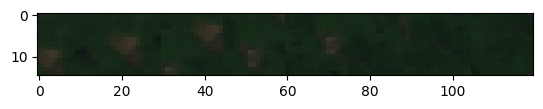

In [10]:
plt.imshow(
    np.concatenate(
        (
            train_images[2, [3,2,1], :, :].T / 4095, 
            train_images[3, [3,2,1], :, :].T / 4095,
            train_images[4, [3,2,1], :, :].T / 4095,
            train_images[5, [3,2,1], :, :].T / 4095,
            train_images[6, [3,2,1], :, :].T / 4095,
            train_images[7, [3,2,1], :, :].T / 4095,
            train_images[8, [3,2,1], :, :].T / 4095,
            train_images[9, [3,2,1], :, :].T / 4095,
            )
            , axis=1))

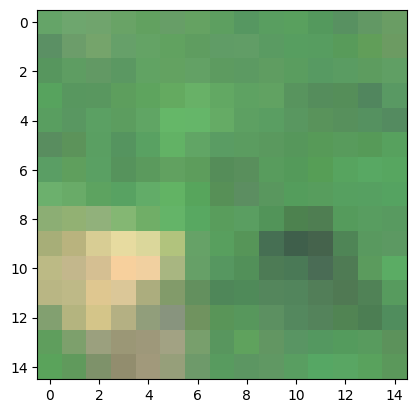

In [19]:
plt.imshow(train_images[2, [3,2,1], :, :].T / 4095 * 4)

In [11]:
plt.imshow(train_images[1,:,:,:].mean(axis=1))

NameError: name 'train_images' is not defined

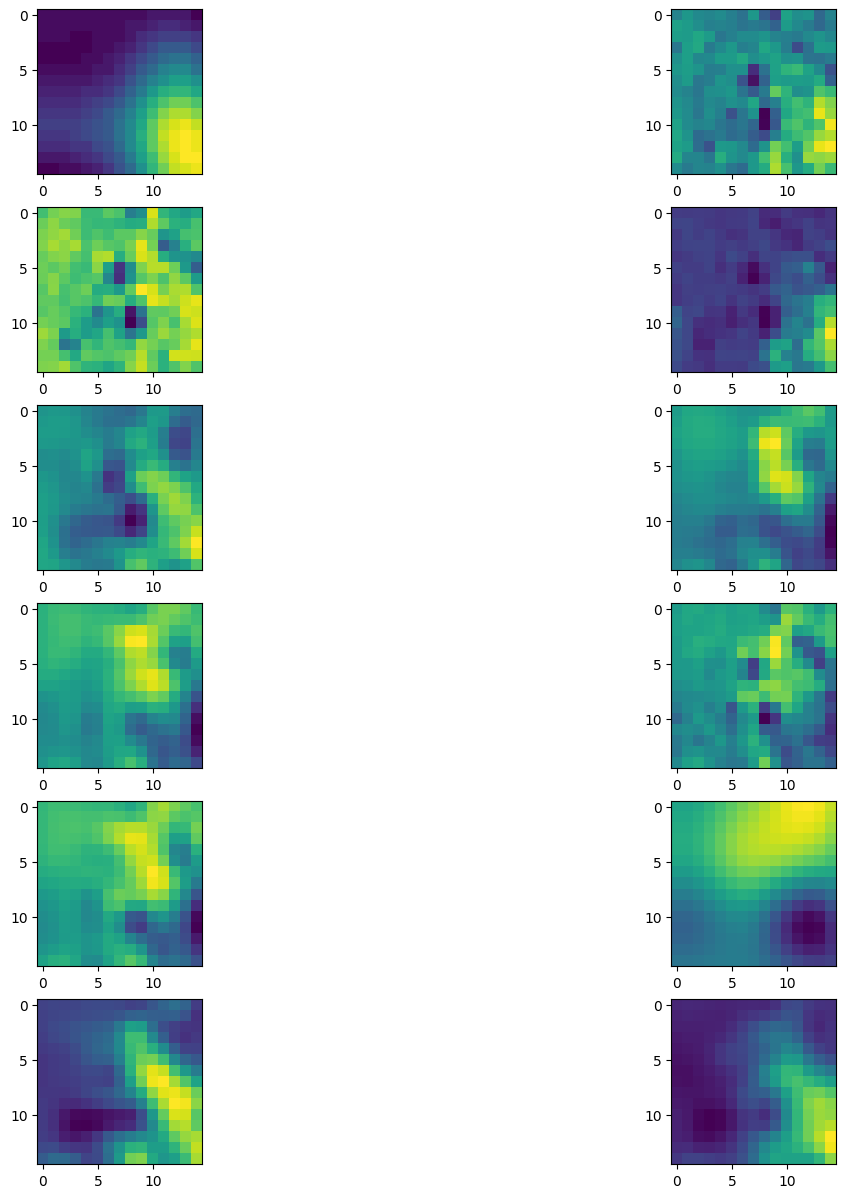

In [10]:
fig, axs = plt.subplots(6, 2, figsize=(15, 15))
axs[0, 0].imshow(train_images[1,0,:,:])
axs[0, 1].imshow(train_images[1,1,:,:])
axs[1, 0].imshow(train_images[1,2,:,:])
axs[1, 1].imshow(train_images[1,3,:,:])
axs[2, 0].imshow(train_images[1,4,:,:])
axs[2, 1].imshow(train_images[1,5,:,:])
axs[3, 0].imshow(train_images[1,6,:,:])
axs[3, 1].imshow(train_images[1,7,:,:])
axs[4, 0].imshow(train_images[1,8,:,:])
axs[4, 1].imshow(train_images[1,9,:,:])
axs[5, 0].imshow(train_images[1,10,:,:])
axs[5, 1].imshow(train_images[1,11,:,:])


In [12]:
train_biomasses[1]

99.10187530517578

 **Below we explore the skewness of train dataset in each channel**

In [13]:
band_skewness = []
band_skewness_after_sqrt = []
for c in range(12):
    #calculate skewness
    band_skewness.append(pd.Series(train_images[:,c].flatten()).skew())
    #calculate skewness after applying sqrt
    band_skewness_after_sqrt.append(pd.Series(np.sqrt(train_images[:,c].flatten())).skew())

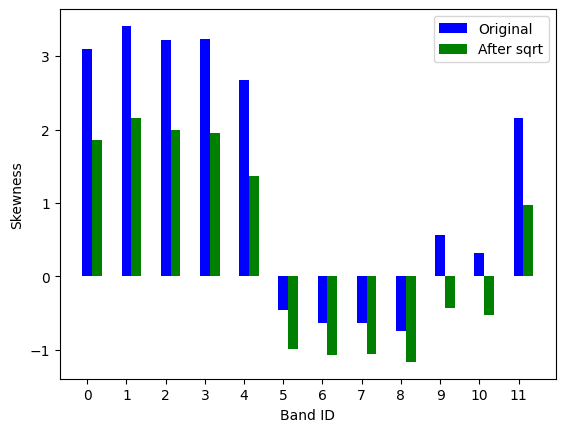

In [14]:
# skweness
width = 0.25

rng = [i for i in range(0,12)]
rng2 = [i+width for i in range(0,12)]

plt.bar(rng, band_skewness, align='center', width = width, label='Original', color ='b')
plt.bar(rng2, band_skewness_after_sqrt, align='center', width = width, label='After sqrt', color ='g')
plt.gca().set_xticks(rng)
plt.legend()
plt.xlabel('Band ID')
plt.ylabel('Skewness')
plt.show()

# First Baseline With Sklearn

In [15]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [16]:
from sklearn import set_config
set_config(display='diagram')

## Modelisation

### Pipeline of training

In [17]:
# constante for standardization
MEAN = train_images.mean((0,2,3))
STD = train_images.std((0,2,3))

In [18]:
class CustomScaler(BaseEstimator, TransformerMixin):
  def __init__(self,mean,std):
    self.mean = mean
    self.std = std
  
  def fit(self, X, y=None):
    #self.mean = X.mean((0,2,3)) 
    #self.std = X.std((0,2,3))
    return self

  def transform(self, X, y=None):
    return (X-self.mean[None,:,None,None])/self.std[None,:,None,None] 

    
class FlattenTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    return X.reshape((X.shape[0], -1))


pipe = Pipeline(steps=[("scaler", CustomScaler(MEAN,STD)),
                       ("flatten", FlattenTransformer()),
                       ("classifier", Lasso())
])

In [19]:
pipe.fit(train_images,train_biomasses)

: 

: 

In [ ]:
# predict
pred_train = pipe.predict(train_images)

# train mse error
mse = mean_squared_error(train_biomasses, pred_train) 
mse
#rmse = np.sqrt(mse)

3023.555305378208

In [ ]:
# predict
pred_validate = pipe.predict(validate_images)

#  validate mse error
mse = mean_squared_error(validate_biomasses, pred_validate) 
mse
#rmse = np.sqrt(mse)

3961.942859655493

### Gridsearch

In [ ]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier'] = [LinearRegression()]

param2 = {}
param2['classifier__alpha'] = [0.1, 0.5, 1]
param2['classifier'] = [Ridge()]

param3 = {}
param3['classifier__alpha'] = [0.1, 0.5, 1]
param3['classifier'] = [Lasso()]

param4 = {}
param4['classifier__n_neighbors'] = [2,5,10,25,50]
param4['classifier'] = [KNeighborsRegressor()]

"""
param5 = {}
param5['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param5['classifier__epsilon'] = [0.0,0.2,0.5,1]
param5['classifier'] = [LinearSVR()]
"""

"\nparam5 = {}\nparam5['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]\nparam5['classifier__epsilon'] = [0.0,0.2,0.5,1]\nparam5['classifier'] = [LinearSVR()]\n"

In [ ]:
pipeline = pipe = Pipeline(steps=[("scaler", CustomScaler(MEAN,STD)),
                       ("flatten", FlattenTransformer()),
                       ("classifier", LinearRegression())])
params = [param1, param2, param3, param4] # param5


In [ ]:
# Train the grid search model
grid_search = GridSearchCV(pipeline, params, cv=3, scoring='neg_mean_squared_error').fit(train_images,train_biomasses)

In [ ]:
# Best performing model and its corresponding hyperparameters
grid_search.best_params_

In [ ]:
model = grid_search.best_estimator_
# predict
pred = model.predict(train_images)

# validate mse error
mse = mean_squared_error(train_biomasses, pred) 
rmse = np.sqrt(mse)

print(mse, rmse)

In [ ]:
model = grid_search.best_estimator_
# predict
pred = model.predict(validate_images)

# validate mse error
mse = mean_squared_error(validate_biomasses, pred) 
rmse = np.sqrt(mse)

print(mse, rmse)

### Predict GIZ Biomass

In [ ]:
s2_images_h5 = h5py.File("/content/images_test.h5", "r")

In [ ]:
#prepare test set sentinel 2 images 
s2_images = np.array(s2_images_h5["images"])
s2_images = s2_images.transpose(0,3,1,2)

In [ ]:
# predict on giz test data
pred_giz = pipe.predict(s2_images)

In [ ]:
ID_S2_pair = pd.read_csv('/content/UniqueID-SentinelPair.csv')

preds = pd.DataFrame({'Target':pred_giz}).rename_axis('S2_idx').reset_index()
preds = ID_S2_pair.merge(preds, on='S2_idx').drop(columns=['S2_idx'])

In [ ]:
preds.to_csv('GIZ_Biomass_predictions.csv', index=False)

In [ ]:
preds

,ID,Target
0,ID_1EB0DGFP07,26.220862
1,ID_844T2PSXTK,39.863222
2,ID_4MCV3S8MLN,39.037564
3,ID_L7441JV5F3,41.643822
4,ID_5GUVM4YEWZ,42.443223
...,...,...
85,ID_MEW6189J1B,54.941441
86,ID_TH9HRUXGTP,47.551169
87,ID_GPC7YS3JG8,55.395363
88,ID_1P7PJMPV0R,35.624857
